## HCP individualized connectome prediction

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset, DataLoader
from data.data_utils import *

In [2]:
participants_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/HCP-YA_dataset/participants.tsv"
participants_df = pd.read_csv(participants_path, sep='\t')

In [3]:
participants_df.head()

,participant_id,subject,age,sex,train_val_test
0,sub-100206,100206,27,M,train
1,sub-100307,100307,27,F,train
2,sub-100408,100408,33,M,val
3,sub-100610,100610,27,M,train
4,sub-101006,101006,35,F,val


In [4]:
# Option to select either "Glasser" or "S456" parcellation
parcellation = "Glasser"  # options: "Glasser" or "S456"

if parcellation == "S456":
    # Use 4S456Parcels data
    sc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_SCifod2actvolnorm.mat"
    fc_mat_path = "/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_4S456Parcels_FCcorrhpf.mat"
elif parcellation == "Glasser":
    # Use Glasser data
    sc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_SCifod2actvolnorm.mat"
    fc_mat_path = f"/scratch/asr655/neuroinformatics/Conn2Conn/krakencoder/example_data/mydata_Glasser_FCcorrhpf.mat"
else:
    raise ValueError(f'Invalid parcellation: must be "Glasser" or "S456"')

# Load the structural connectivity (SC) .mat file
sc_mat = scipy.io.loadmat(sc_mat_path)

sc_subjects = sc_mat['subjects']
sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]

sc_cell = sc_mat['SC']
sc_cell = np.squeeze(sc_cell)  # Make 1D if needed
n_sc_subj = sc_cell.shape[0]
# Each element is nparcel x nparcel
sc_matrices = np.stack([sc_cell[i] for i in range(n_sc_subj)], axis=0)
sc_triangles = np.stack([square2tri(sc_matrices[i], k=1) for i in range(n_sc_subj)], axis=0)

# Load the functional connectivity (FC) .mat file
fc_mat = scipy.io.loadmat(fc_mat_path)

fc_subjects = fc_mat['subjects']
fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]

fc_cell = fc_mat['FC']
fc_cell = np.squeeze(fc_cell)  # Make 1D if needed
n_fc_subj = fc_cell.shape[0]
# Each element is nparcel x nparcel
fc_matrices = np.stack([fc_cell[i] for i in range(n_fc_subj)], axis=0)
fc_triangles = np.stack([square2tri(fc_matrices[i], k=1) for i in range(n_fc_subj)], axis=0)

/tmp/ipykernel_1240532/1198866335.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sc_subjects = [int(np.squeeze(subj)) for subj in sc_subjects]
/tmp/ipykernel_1240532/1198866335.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fc_subjects = [int(np.squeeze(subj)) for subj in fc_subjects]


In [5]:
print("fc_subjects shape:", np.shape(fc_subjects))
print("fc_matrices shape:", fc_matrices.shape)
print("fc_triangles shape:", fc_triangles.shape, '\n')

print("sc_subjects shape:", np.shape(sc_subjects))
print("sc_matrices shape:", sc_matrices.shape)
print("sc_triangles shape:", sc_triangles.shape)


fc_subjects shape: (957,)
fc_matrices shape: (957, 360, 360)
fc_triangles shape: (957, 64620) 

sc_subjects shape: (957,)
sc_matrices shape: (957, 360, 360)
sc_triangles shape: (957, 64620)


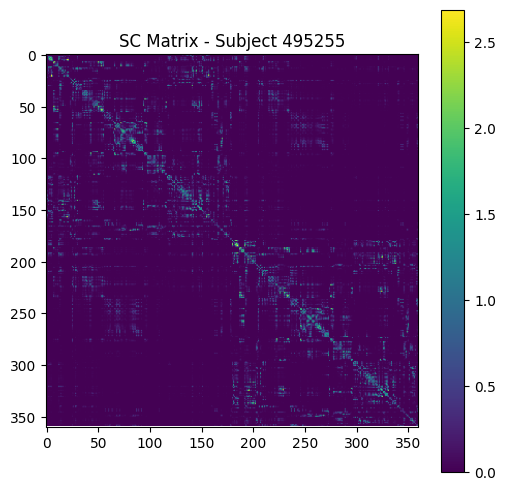

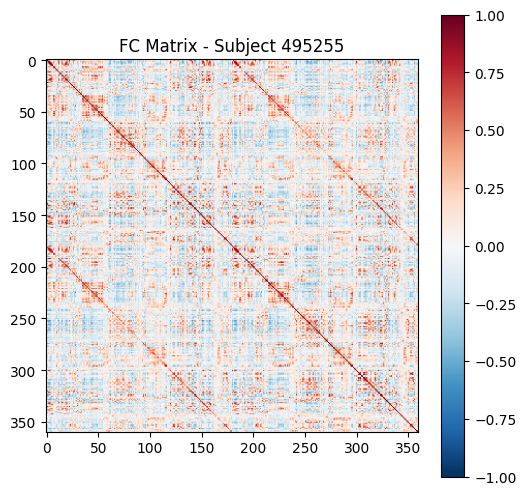

In [6]:
import random
import matplotlib.pyplot as plt

# Pick a random subject index that is present in both SC and FC sets
common_subjects = list(set(sc_subjects) & set(fc_subjects))
if not common_subjects:
    raise ValueError("No subjects in common between SC and FC datasets.")

# Choose a random subject
rand_subject = random.choice(common_subjects)

# Find index of this subject in sc_subjects and fc_subjects
sc_idx = sc_subjects.index(rand_subject)
fc_idx = fc_subjects.index(rand_subject)

# Get the full matrices (not just triangles)
sc_matrix = sc_matrices[sc_idx]
fc_matrix = fc_matrices[fc_idx]

# Plot SC matrix (ensure image is square)
plt.figure(figsize=(6, 6))
plt.imshow(sc_matrix, aspect='equal', cmap='viridis')
plt.title(f"SC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()

# Plot FC matrix (ensure image is square) with colormap RdBu_r and colorbar from -1 to 1
plt.figure(figsize=(6, 6))
plt.imshow(fc_matrix, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
plt.title(f"FC Matrix - Subject {rand_subject}")
plt.colorbar()
plt.show()


Data loader logic walk through

In [50]:
import importlib
import data.hcp_dataset
import data.dataset_utils 
import data.data_utils
importlib.reload(data.hcp_dataset)
importlib.reload(data.dataset_utils)
importlib.reload(data.data_utils)
from data.hcp_dataset import *
from data.dataset_utils import *
from data.data_utils import *

In [51]:
from data.hcp_dataset import HCP_Base

In [52]:
HCP_Dataset = HCP_Base(parcellation="Glasser", shuffle_seed=0)

In [54]:
HCP_Dataset.metadata_df.head()

,subject,train_val_test,age,age_3y_bin,sex,Race_Ethnicity,Family_Relation,Family_ID
0,100206,train,27,25-27,M,White_Not Hispanic/Latino,NotTwin,56037_85858
1,100307,train,27,25-27,F,White_Not Hispanic/Latino,MZ,51488_81352
2,100408,val,33,31-33,M,White_Not Hispanic/Latino,MZ,51730_81594
3,100610,train,27,25-27,M,White_Not Hispanic/Latino,DZ,52813_82634
4,101006,val,35,34-36,F,Black or African Am._Not Hispanic/Latino,MZ,51283_52850_81149


In [25]:
HCP_Dataset.freesurfer_df.head()

,subject,FS_IntraCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,FS_SubCort_GM_Vol,FS_Total_GM_Vol,...,FS_R_Rostralanteriorcingulate_Area,FS_R_Rostralmiddlefrontal_Area,FS_R_Superiorfrontal_Area,FS_R_Superiorparietal_Area,FS_R_Superiortemporal_Area,FS_R_Supramarginal_Area,FS_R_Frontalpole_Area,FS_R_Temporalpole_Area,FS_R_Transversetemporal_Area,FS_R_Insula_Area
1,100206,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488.0,305634.0,610122.0,70240.0,807245.0,...,791.0,8627.0,8515.0,6315.0,4337.0,3522.0,356.0,500.0,384.0,2267.0
2,100307,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030.0,243207.0,483238.0,56623.0,664124.0,...,505.0,5702.0,6463.0,4538.0,3441.0,3613.0,257.0,412.0,375.0,2385.0
3,100408,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695.0,265243.0,525938.0,63869.0,726206.0,...,631.0,7092.0,7484.0,5367.0,3984.0,4144.0,298.0,410.0,421.0,2578.0
4,100610,1.816044e+06,1321362.0,1306929.0,1.304569e+06,276506.0,278002.0,554508.0,74869.0,762308.0,...,629.0,7027.0,7088.0,6820.0,3876.0,3730.0,298.0,393.0,337.0,2792.0
5,101006,1.437868e+06,1053766.0,1038408.0,1.037793e+06,203718.0,210539.0,414257.0,58813.0,579632.0,...,649.0,4672.0,5639.0,5032.0,3088.0,3416.0,257.0,471.0,336.0,2290.0


SC Train vs Val Pearson r: 0.9984552
SC Train vs Test Pearson r: 0.99930215
SC Val vs Test Pearson r: 0.9980919


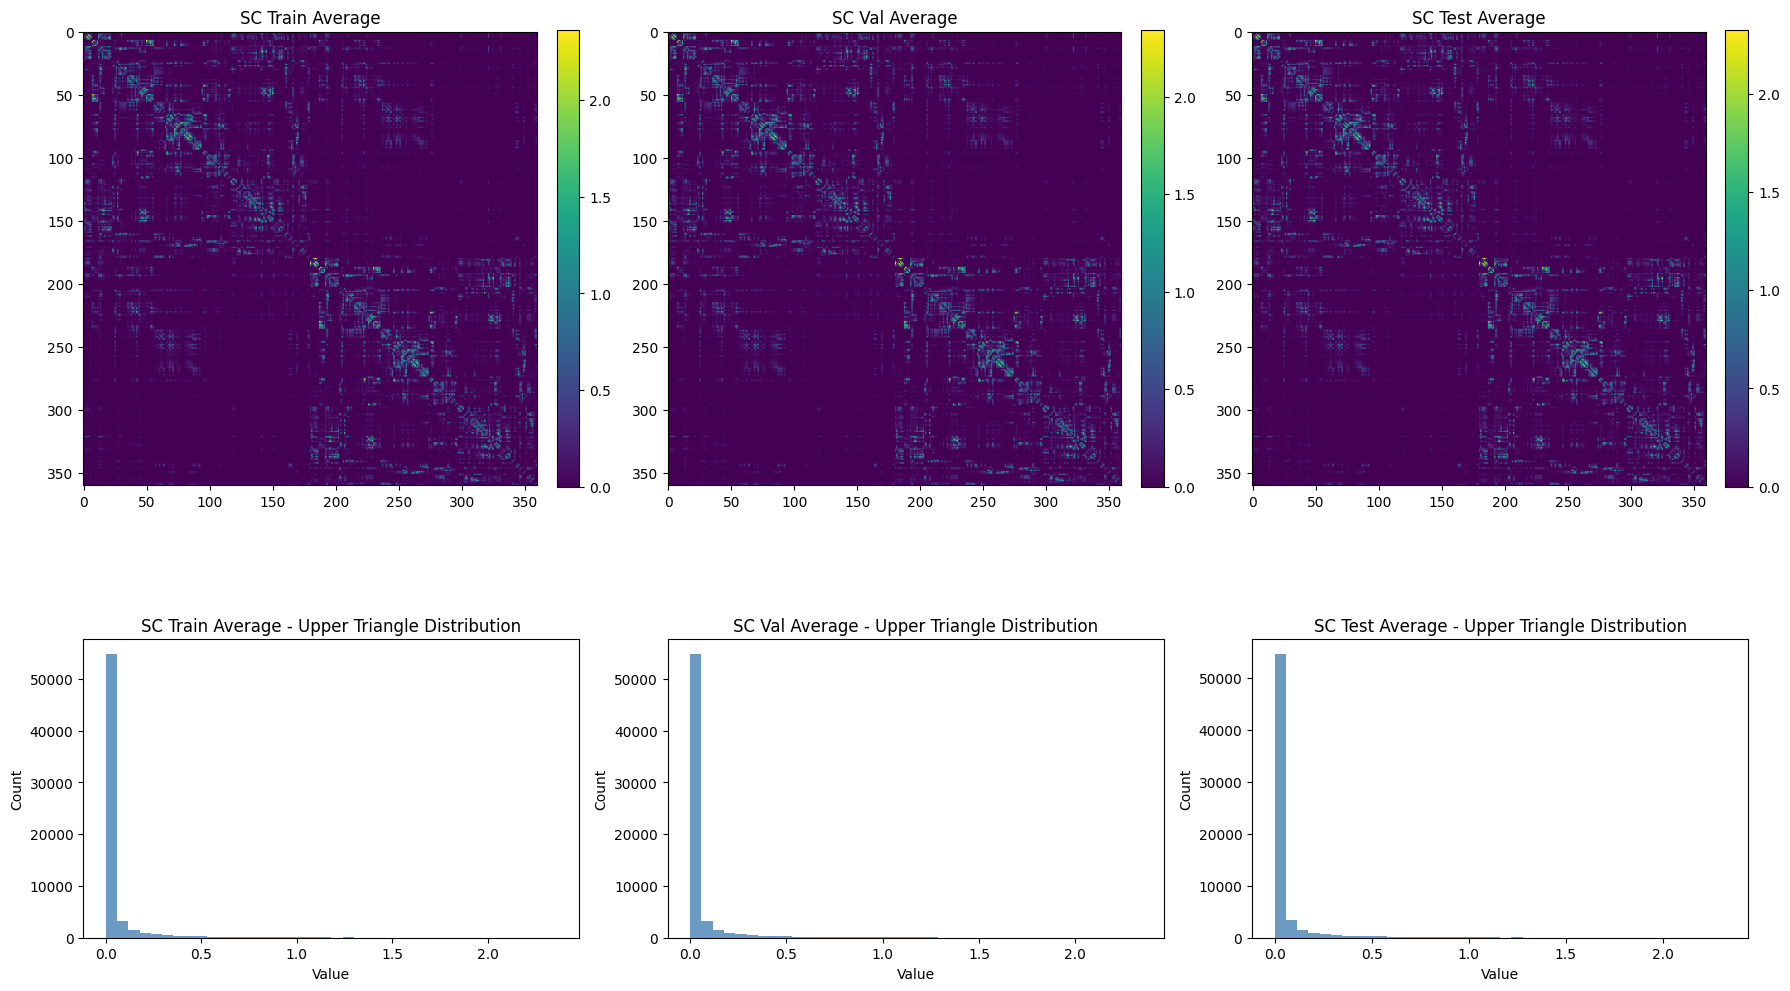

FC Train vs Val Pearson r: 0.9963651
FC Train vs Test Pearson r: 0.99826103
FC Val vs Test Pearson r: 0.9963004


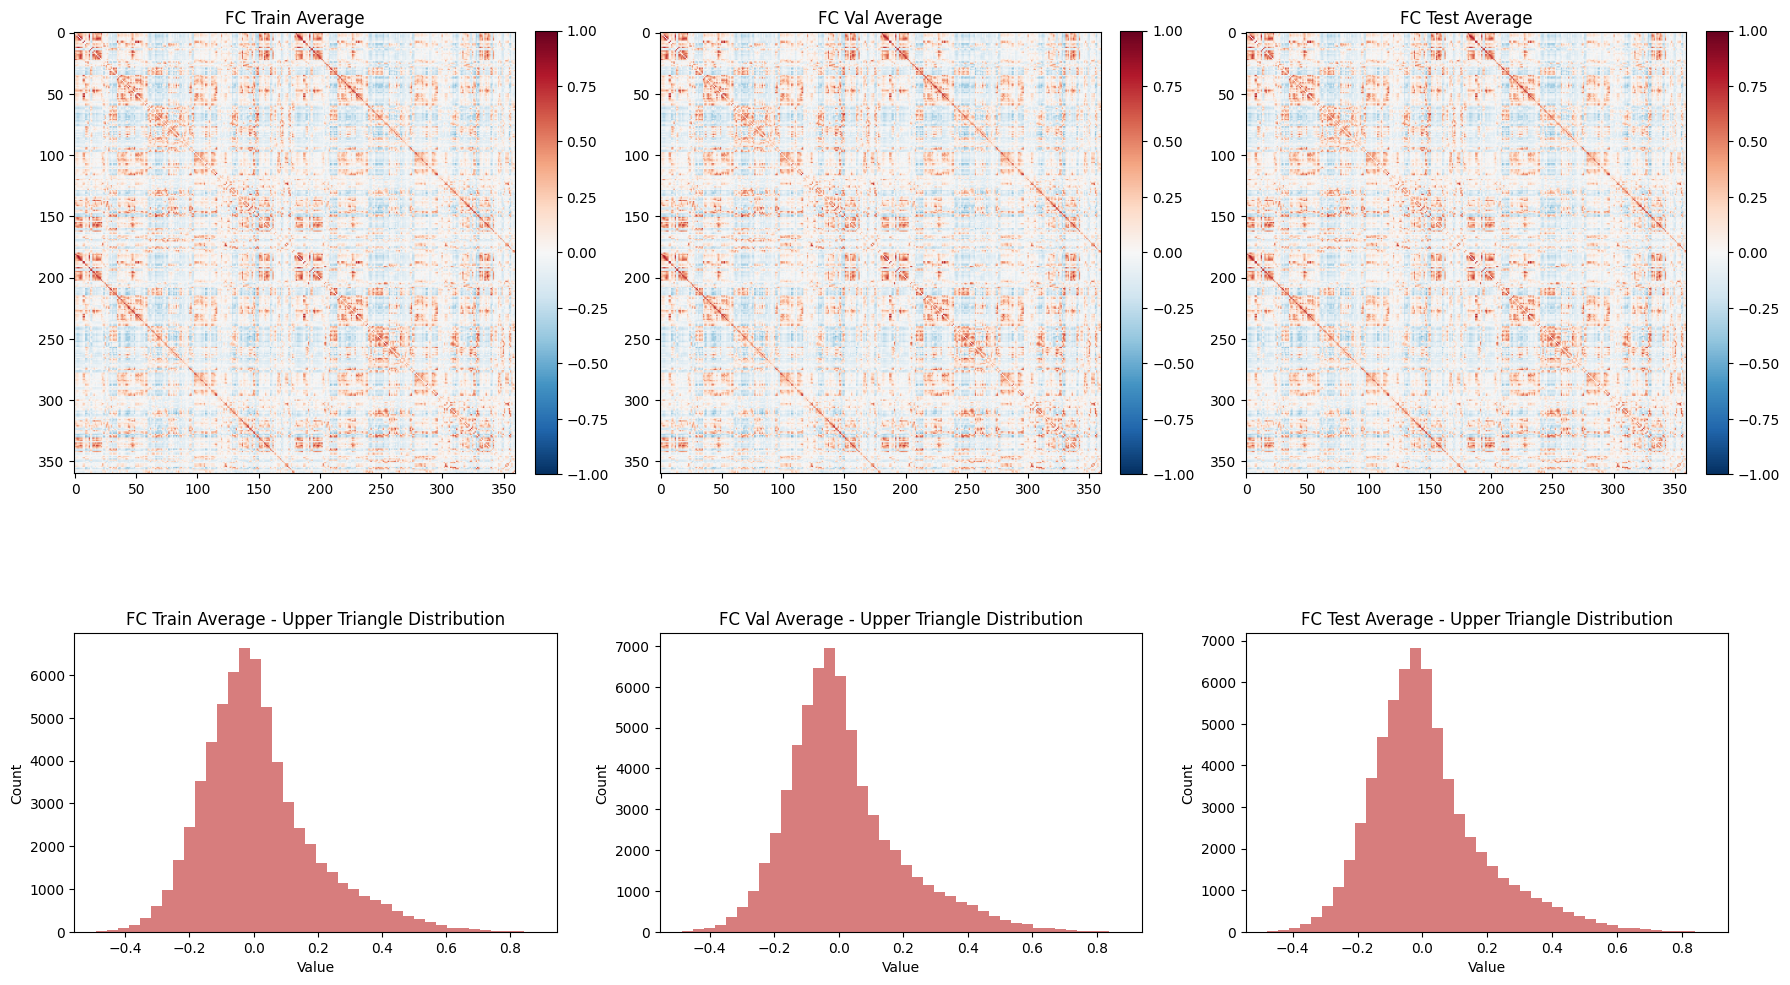

In [58]:
# Plot average SC matrices for train, val, test splits using tri2square
sc_tri_indices = np.triu_indices(sc_matrices.shape[1], k=1)
sc_train_avg_mat = tri2square(HCP_Dataset.SC_train_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)
sc_val_avg_mat = tri2square(HCP_Dataset.SC_val_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)
sc_test_avg_mat = tri2square(HCP_Dataset.SC_test_avg.detach().cpu().numpy(), tri_indices=sc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average SCs
from scipy.stats import pearsonr

def tri_corr(mat1, mat2):
    # extract upper triangle without diagonal, flatten
    iu = np.triu_indices_from(mat1, k=1)
    return pearsonr(mat1[iu], mat2[iu])[0]

print("SC Train vs Val Pearson r:", tri_corr(sc_train_avg_mat, sc_val_avg_mat))
print("SC Train vs Test Pearson r:", tri_corr(sc_train_avg_mat, sc_test_avg_mat))
print("SC Val vs Test Pearson r:", tri_corr(sc_val_avg_mat, sc_test_avg_mat))

# PLOT: imshow and histogram for each SC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
sc_avg_mats = [sc_train_avg_mat, sc_val_avg_mat, sc_test_avg_mat]
sc_titles = ["SC Train Average", "SC Val Average", "SC Test Average"]

for i, (mat, title) in enumerate(zip(sc_avg_mats, sc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='viridis')
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='steelblue', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()

# Plot average FC matrices for train, val, test splits using tri2square
fc_tri_indices = np.triu_indices(fc_matrices.shape[1], k=1)
fc_train_avg_mat = tri2square(HCP_Dataset.FC_train_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)
fc_val_avg_mat = tri2square(HCP_Dataset.FC_val_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)
fc_test_avg_mat = tri2square(HCP_Dataset.FC_test_avg.detach().cpu().numpy(), tri_indices=fc_tri_indices)

# Print the similarity (Pearson correlation) between each pair of average FCs
print("FC Train vs Val Pearson r:", tri_corr(fc_train_avg_mat, fc_val_avg_mat))
print("FC Train vs Test Pearson r:", tri_corr(fc_train_avg_mat, fc_test_avg_mat))
print("FC Val vs Test Pearson r:", tri_corr(fc_val_avg_mat, fc_test_avg_mat))

# PLOT: imshow and histogram for each FC split
fig, axs = plt.subplots(2, 3, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
fc_avg_mats = [fc_train_avg_mat, fc_val_avg_mat, fc_test_avg_mat]
fc_titles = ["FC Train Average", "FC Val Average", "FC Test Average"]

for i, (mat, title) in enumerate(zip(fc_avg_mats, fc_titles)):
    # Imshow
    im = axs[0, i].imshow(mat, aspect='equal', cmap='RdBu_r', vmin=-1, vmax=1)
    axs[0, i].set_title(title)
    fig.colorbar(im, ax=axs[0, i], fraction=0.046, pad=0.04)
    # Histogram of upper triangle (excluding diagonal)
    iu = np.triu_indices_from(mat, k=1)
    axs[1, i].hist(mat[iu], bins=40, color='indianred', alpha=0.8)
    axs[1, i].set_xlabel('Value')
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_title(f'{title} - Upper Triangle Distribution')
plt.tight_layout()
plt.show()


### PCA info loss eval

Loadings shape (n_components, n_features): (683, 64620)
Train scores shape (n_train_samples, n_components): (683, 683)


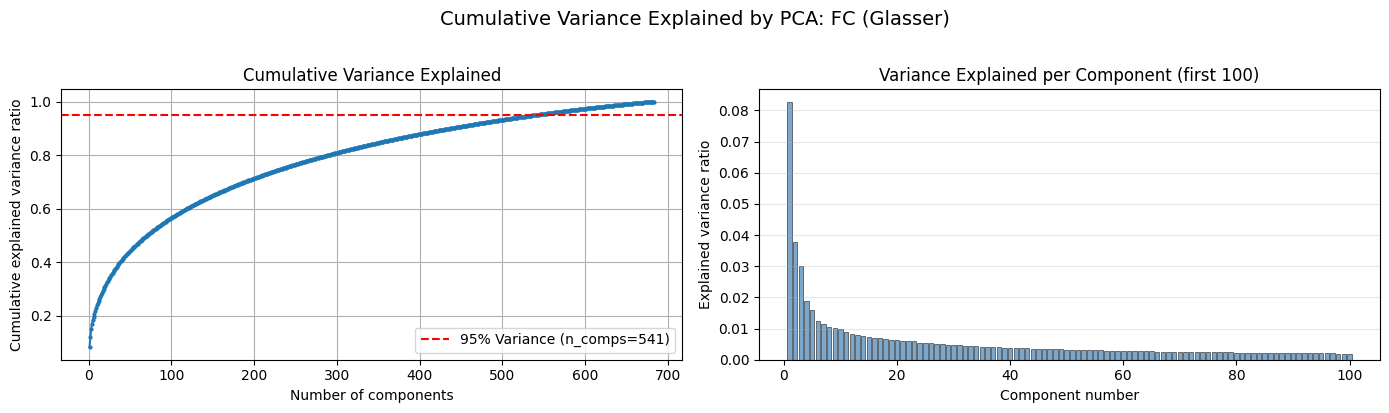

128 components: Train R^2: 0.58524  Val R^2: 0.35478  Test R^2: 0.37567
256 components: Train R^2: 0.74561  Val R^2: 0.40393  Test R^2: 0.42183
512 components: Train R^2: 0.92866  Val R^2: 0.45083  Test R^2: 0.46657


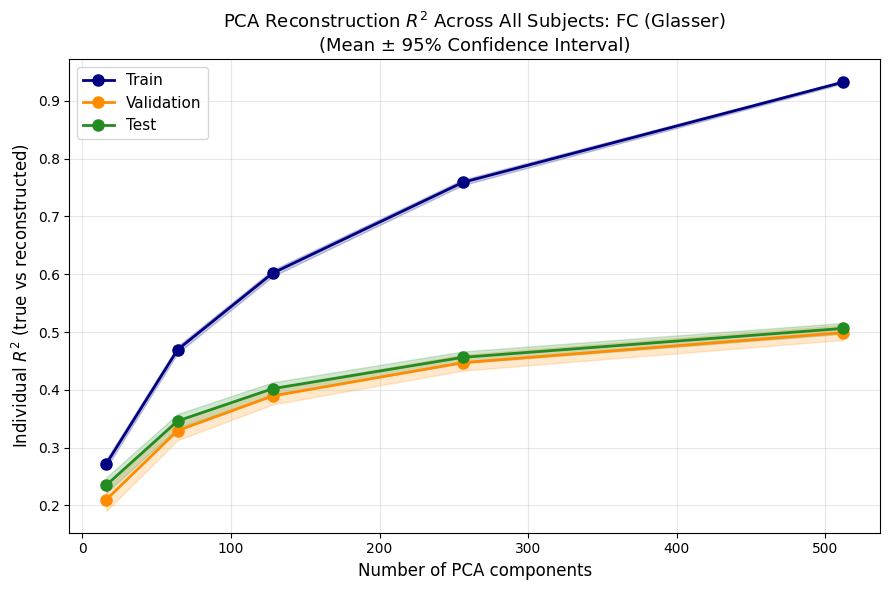

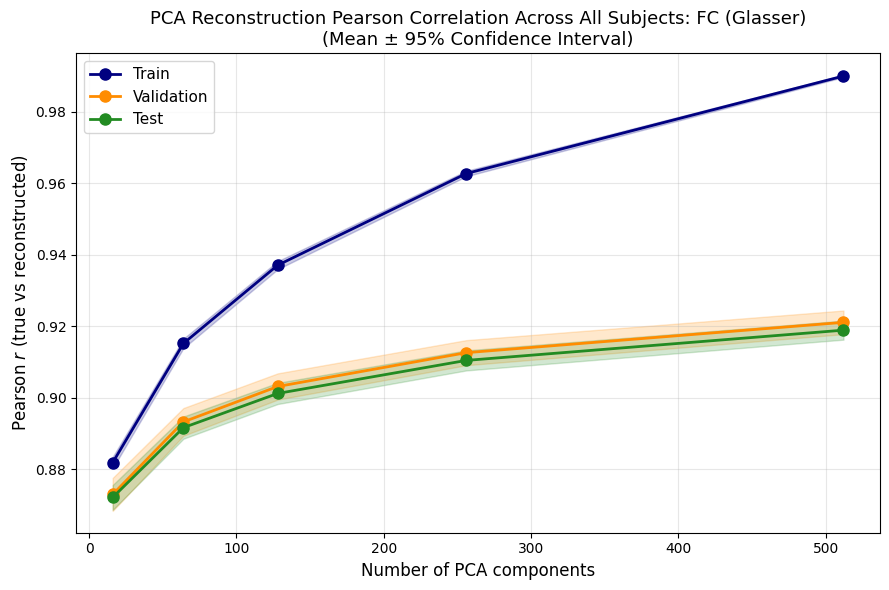

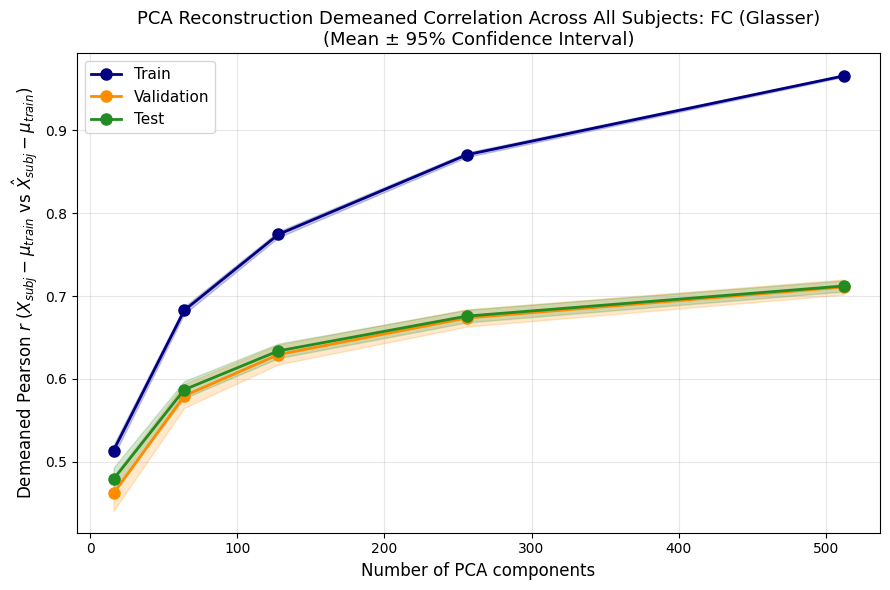

In [59]:
# how much info loss is attributable to PCA?

import models
import importlib
importlib.reload(models)
from models import *

# Example usage:
FC_train_np = HCP_Dataset.FC_train.detach().cpu().numpy()
FC_val_np = HCP_Dataset.FC_val.detach().cpu().numpy()
FC_test_np = HCP_Dataset.FC_test.detach().cpu().numpy()

pca, scores_dict, loadings = run_pca_and_plot(
    FC_train_np, FC_val_np, FC_test_np, 
    train_ids=HCP_Dataset.train_subject_ids, 
    val_ids=HCP_Dataset.val_subject_ids, 
    test_ids=HCP_Dataset.test_subject_ids,
    modality="FC", parcellation="Glasser")



Loadings shape (n_components, n_features): (683, 64620)
Train scores shape (n_train_samples, n_components): (683, 683)


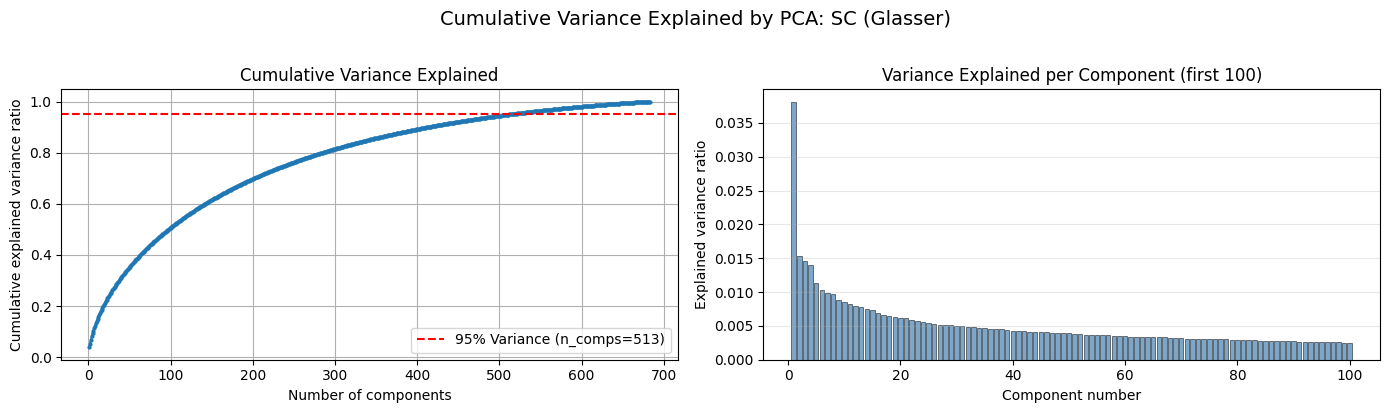

128 components: Train R^2: 0.40487  Val R^2: 0.10091  Test R^2: 0.11184
256 components: Train R^2: 0.59228  Val R^2: 0.07313  Test R^2: 0.09387
512 components: Train R^2: 0.86372  Val R^2: -0.03034  Test R^2: 0.01363


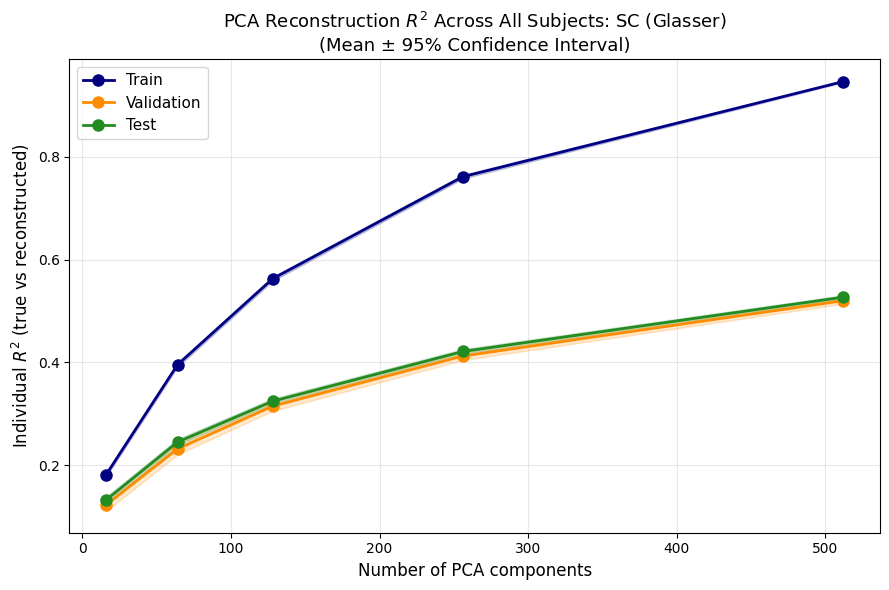

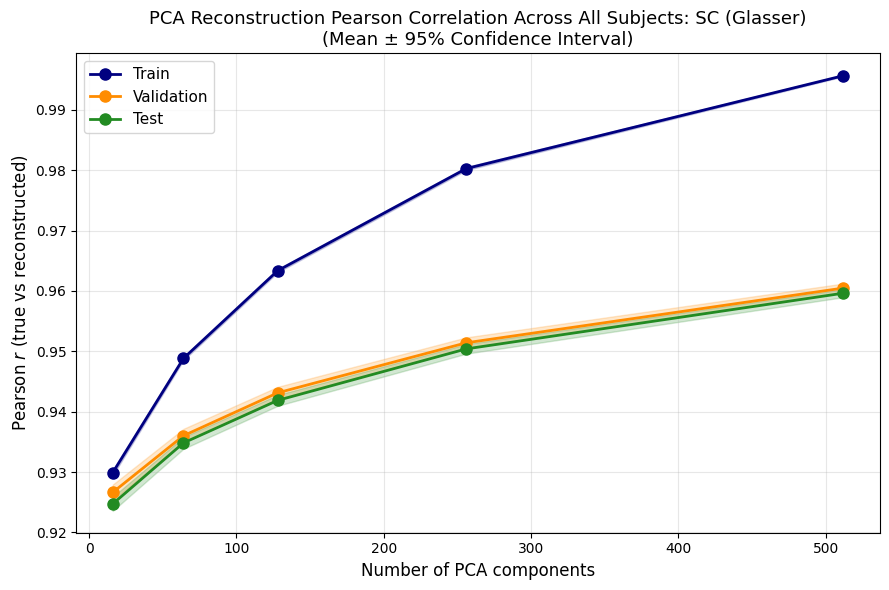

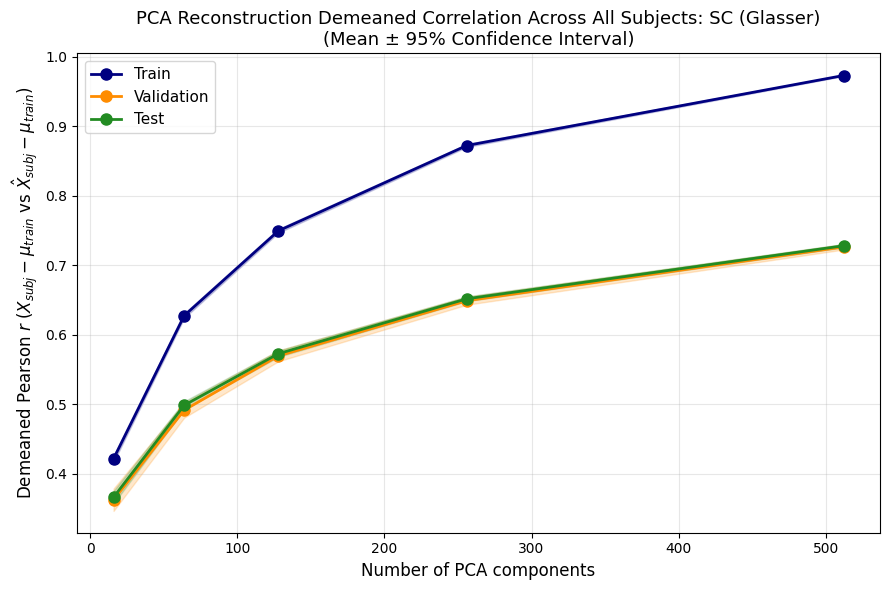

In [60]:
# how much info loss is attributable to PCA? (for SC)

import models
import importlib
importlib.reload(models)
from models import *

# Example usage for SC:
SC_train_np = HCP_Dataset.SC_train.detach().cpu().numpy()
SC_val_np = HCP_Dataset.SC_val.detach().cpu().numpy()
SC_test_np = HCP_Dataset.SC_test.detach().cpu().numpy()

pca, scores_dict, loadings = run_pca_and_plot(
    SC_train_np, SC_val_np, SC_test_np, 
    train_ids=HCP_Dataset.train_subject_ids, 
    val_ids=HCP_Dataset.val_subject_ids, 
    test_ids=HCP_Dataset.test_subject_ids,
    modality="SC", parcellation="Glasser")

